<a href="https://colab.research.google.com/github/Wisley1/Genes_ITMO_FALL23/blob/analysis/neuro_try.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# @title Transposed data prep
import requests
import pickle
import pandas as pd
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
!pip install keras
import numpy as np
from keras.models import Sequential
from keras.layers import Dense
from sklearn.metrics import r2_score

from sklearn.model_selection import train_test_split
from tensorflow import keras

#цепляем файлики
url_1 = '/content/drive/MyDrive/Colab Notebooks/ITMO FALL 23`/genes_features_normalized.pkl'
url_2 = '/content/drive/MyDrive/Colab Notebooks/ITMO FALL 23`/genes_targets_normalized.pkl'

#открываем
with open(url_1, 'rb') as file: #features
    data = pickle.load(file)

with open(url_2, 'rb') as file: #targets
    targets = pickle.load(file)

#достаем нужный таргет
targets = targets.loc[targets['ENTITY_STABLE_ID'] == 'AGRN']

#объединяем
df = pd.concat([targets, data])


#вы готовы
df = df.transpose()
df.head()

,70,266,267,268,269,270,271,272,273,274,...,55781,55782,55783,55784,55785,55786,55787,55788,55789,55790
ENTITY_STABLE_ID,AGRN,RP11-431K24.2,RNU1-7P,RP11-431K24.3,RP11-431K24.4,RN7SL729P,RNU6-991P,SLC45A1,Y_RNA,RERE,...,MT-ND3,MT-TR,MT-TH,MT-TS2,MT-TL2,MT-ND5,MT-ND6,MT-TE,MT-CYB,MT-TT
SKES1_BONE,3.539882,0.0,0.0,0.0,0.0,0.0,0.0,0.69802,0.0,3.470423,...,8.057696,0.254732,0.086583,0.0,0.424418,7.955328,7.77447,0.313495,7.875009,0.0
NCIH1395_LUNG,3.728295,0.0,0.0,0.014842,0.0,0.0,0.0,0.168451,0.0,1.931191,...,7.875009,0.248075,0.0,0.0,0.228576,7.77447,8.057696,0.821715,8.456017,0.0
8MGBA_CENTRAL_NERVOUS_SYSTEM,3.928495,0.018358,0.0,0.0,0.0,0.0,0.0,0.374135,0.0,2.582173,...,7.617393,0.267049,0.0,0.147359,0.183919,7.240781,6.870244,0.126934,7.690037,0.064632
GB1_CENTRAL_NERVOUS_SYSTEM,3.564631,0.0,0.0,0.0,0.0,0.0,0.0,0.80615,0.0,2.413654,...,7.311097,0.0,0.0,0.0,0.0,6.850733,6.595865,0.193022,7.690037,0.0


In [2]:
# @title Delete missing values
df = df.fillna(0)
# Отбор столбцов, где процент нулевых значений больше 50%
null_percentages = df.eq(0).mean()


columns_to_drop = null_percentages[null_percentages > 0.5].index


# Удаление выбранных столбцов
df = df.drop(columns=columns_to_drop)
df = df.drop(index=['ENTITY_STABLE_ID'])

df.head()

,70,272,274,275,279,284,285,286,288,294,...,55776,55778,55780,55781,55783,55785,55786,55787,55788,55789
SKES1_BONE,3.539882,0.69802,3.470423,0.068742,0.049693,7.174483,0.259416,0.365414,0.038536,0.033019,...,2.499865,9.493607,0.501021,8.057696,0.086583,0.424418,7.955328,7.77447,0.313495,7.875009
NCIH1395_LUNG,3.728295,0.168451,1.931191,0.0,0.04572,6.716419,0.447687,0.4399,0.009316,0.136022,...,4.570667,9.493607,0.0,7.875009,0.0,0.228576,7.77447,8.057696,0.821715,8.456017
8MGBA_CENTRAL_NERVOUS_SYSTEM,3.928495,0.374135,2.582173,0.025863,0.0,6.595865,0.118574,0.171211,0.0,0.000153,...,3.175103,9.493607,0.062651,7.617393,0.0,0.183919,7.240781,6.870244,0.126934,7.690037
GB1_CENTRAL_NERVOUS_SYSTEM,3.564631,0.80615,2.413654,0.02518,0.0,8.456017,0.508394,0.433344,0.024122,0.027826,...,2.882694,9.493607,0.0,7.311097,0.0,0.0,6.850733,6.595865,0.193022,7.690037
U87MG_CENTRAL_NERVOUS_SYSTEM,3.138672,1.309224,1.860857,0.068531,0.0,7.690037,0.549374,0.143224,0.0,0.035245,...,2.745861,9.493607,0.0,7.174483,0.0,0.0,6.748965,6.99242,0.25051,7.441481


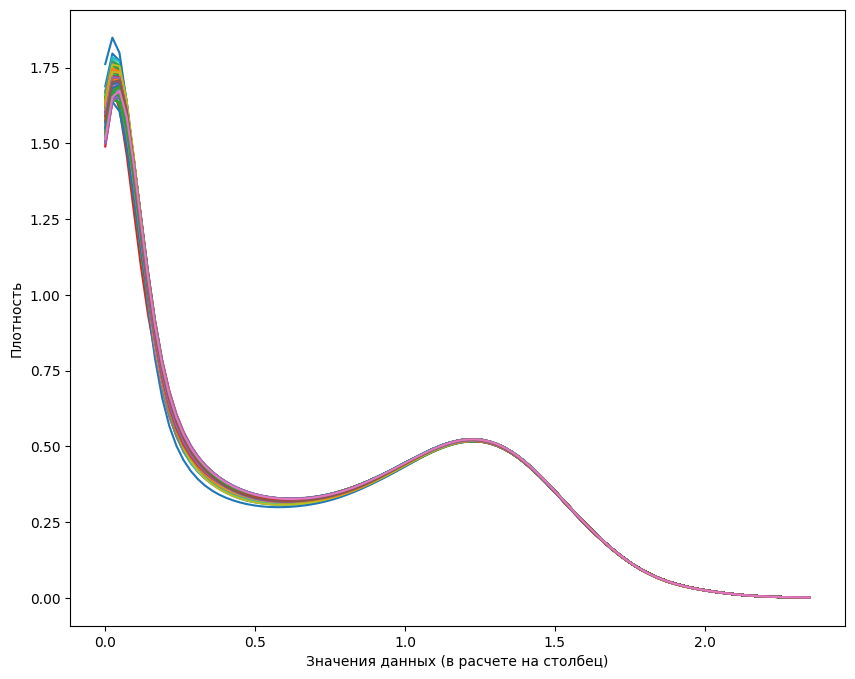

In [ ]:
# @title Plot col density
def plot_col_density(data):
    # Применить гауссово сглаживание с целью получения оценки плотности
    density_per_col = [stats.gaussian_kde(col) for col in data]
    x = np.linspace(np.min(data), np.max(data), 100)

    # Установите желаемые значения ширины и высоты
    fig, ax = plt.subplots(figsize=(10, 8))

    for density in density_per_col:
        ax.plot(x, density(x))

    ax.set_xlabel('Значения данных (в расчете на столбец)')
    ax.set_ylabel('Плотность')

    plt.show()

counts = df.iloc[1:,:].values.astype(float)

# До нормализации
log_counts = np.log(counts + 1)
plot_col_density(log_counts)

In [3]:
# @title Most Varibale Rows
def most_variable_rows(data, *, n=1500):
# Вычислить дисперсию вдоль оси столбцов
  rowvar = np.var(data, axis=1)
# Получить отсортированные индексы (в порядке возрастания), взять последние n
  sort_indices = np.argsort(rowvar)[-n:]
# Использовать в качестве индекса для данных
  variable_data = data[sort_indices, :]
  return variable_data

In [ ]:
# @title Bicluster
from scipy.cluster.hierarchy import linkage
def bicluster(data, linkage_method='average', distance_metric='correlation'):

  y_rows = linkage(data, method=linkage_method, metric=distance_metric)
  y_cols = linkage(data.T, method=linkage_method, metric=distance_metric)
  return y_rows, y_cols

In [ ]:
# @title Plot Bicluster
from scipy.cluster.hierarchy import dendrogram, leaves_list
def clear_spines(axes):
  for loc in ['left', 'right', 'top', 'bottom']:
    axes.spines[loc].set_visible(False)
  axes.set_xticks([])
  axes.set_yticks([])


def plot_bicluster(data, row_linkage, col_linkage, row_nclusters=10, col_nclusters=3):

  fig = plt.figure(figsize=(4.8, 4.8))

  ax1 = fig.add_axes([0.09, 0.1, 0.2, 0.6])

  threshold_r = (row_linkage[-row_nclusters, 2] + row_linkage[-row_nclusters + 1, 2]) / 2
  with plt.rc_context({'lines.linewidth': 0.75}):
    dendrogram(row_linkage, orientation='left', color_threshold = threshold_r, ax = ax1)
  clear_spines(ax1)

  ax2 = fig.add_axes([0.3, 0.71, 0.6, 0.2])
  threshold_c = (col_linkage[-col_nclusters, 2] +
  col_linkage[-col_nclusters+1, 2]) / 2
  with plt.rc_context({'lines.linewidth': 0.75}):
    dendrogram(col_linkage, color_threshold=threshold_c, ax=ax2)
  clear_spines(ax2)

  ax = fig.add_axes([0.3, 0.1, 0.6, 0.6])

  idx_rows = leaves_list(row_linkage)
  data = data[idx_rows, :]
  idx_cols = leaves_list(col_linkage)
  data = data[:, idx_cols]
  im = ax.imshow(data, aspect='auto', origin='lower', cmap='YlGnBu_r')
  clear_spines(ax)

  ax.set_xlabel('Образцы')
  ax.set_ylabel('Гены', labelpad=125)

  axcolor = fig.add_axes([0.91, 0.1, 0.02, 0.6])
  plt.colorbar(im, cax=axcolor)

  plt.show()



counts = df.iloc[1:,:].values.astype(float)
counts_log = np.log(counts + 1)
counts_var = most_variable_rows(counts_log, n=1500)
yr, yc = bicluster(counts_var, linkage_method='ward',
distance_metric='euclidean')
plot_bicluster(counts_var, yr, yc)

In [3]:
# @title Classes of Genes
dictionary = {}

for item in df.index:
    last_word = item.split('_')[-1]
    if last_word not in dictionary:
        dictionary[last_word] = []
    dictionary[last_word].append(item)

print(dictionary.keys())

dict_keys(['BONE', 'LUNG', 'SYSTEM', 'GANGLIA', 'OESOPHAGUS', 'BREAST', 'TISSUE', 'SKIN', 'INTESTINE', 'OVARY', 'GLAND', 'STOMACH', 'PLEURA', 'PROSTATE', 'KIDNEY', 'PANCREAS', 'ENDOMETRIUM', 'TRACT', 'PLACENTA', 'CERVIX', 'THYROID', 'LIVER', 'CORTEX', 'FIBROBLAST'])


In [5]:
list_of_columns = []
for index in dictionary:
  frame = df.loc[dictionary[index]]
  X = frame.iloc[:, 1:]  # Выберите все столбцы, кроме первого, как признаки
  y = frame.iloc[:, 0]   # Выберите первый столбец как целевую переменную

  # Создание модели случайного леса и обучение её на данных
  model = RandomForestRegressor()
  model.fit(X, y)

# Получение важности признаков
  importance = model.feature_importances_

# Создание DataFrame с информацией о важности признаков
  importance_df = pd.DataFrame({"Feature": X.columns, "Importance": importance})

# Сортировка по убыванию важности
  importance_df = importance_df.sort_values("Importance", ascending=False)

# Вывод наиболее ценных столбцов (признаков)
  top_features = importance_df.head(30)
  feature_counts = top_features["Feature"]
  list_of_columns.append(feature_counts)

Exception ignored in: <function _xla_gc_callback at 0x7eda410ad1b0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/jax/_src/lib/__init__.py", line 103, in _xla_gc_callback
    def _xla_gc_callback(*args):
KeyboardInterrupt: 


KeyboardInterrupt: ignored

In [ ]:
list_of_columns[1]

12785    26507
5829     11629
19780    40885
14517    29796
736       1490
11651    24070
13316    27443
22915    46424
22963    46513
15119    31276
27209    54330
2793      5388
15052    31186
25517    50898
5336     10649
24215    48621
1703      3249
474       1084
17438    35716
15131    31289
8906     18262
24155    48528
18155    37557
5559     11055
5557     11052
26900    53587
13869    28648
601       1278
13274    27359
26330    52531
Name: Feature, dtype: int64

In [4]:
df.shape

(688, 27636)

In [5]:
from sklearn.model_selection import train_test_split
# Разделение на признаки (X) и целевую переменную (y)
X = df.iloc[:,1:] # Удаление колонки '70' из признаков
y = df.iloc[:,0]  # Целевая переменная - колонка '70'

# Разделение на обучающую и тестовую выборки
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Преобразование данных в массивы NumPy
X_train = np.array(X_train).astype(np.float32)
y_train = np.array(y_train).astype(np.float32)
X_test = np.array(X_test).astype(np.float32)
y_test = np.array(y_test).astype(np.float32)


In [6]:
X_train.shape

(550, 27635)

In [7]:
len(X_train)

550

In [8]:
y_train.shape

(550,)

In [9]:
X_test.shape

(138, 27635)

In [10]:
len(X_test)

138

In [11]:
y_test.shape

(138,)

In [25]:
model = keras.Sequential([
    keras.layers.Flatten(input_shape=(27635,)),
    keras.layers.Dense(64, activation='relu'),
    keras.layers.Dense(1, activation='linear')
])

model.compile(optimizer='adam',
              loss='mean_squared_error',
              metrics=['mse'])

model.fit(X_train, y_train, epochs=10)

y_pred = model.predict(X_test)
mse = np.mean((y_pred - y_test) ** 2)

r2 = r2_score(y_test, y_pred)


print(model.evaluate(X_test, y_test))
print(f"Mean Squared Error: {mse}")
print(f"R^2 Score: {r2}")

Epoch 1/10
18/18 [==============================] - 1s 13ms/step - loss: 1116.8253 - mse: 1116.8253
Epoch 2/10
18/18 [==============================] - 0s 14ms/step - loss: 1.4611 - mse: 1.4611
Epoch 3/10
18/18 [==============================] - 0s 17ms/step - loss: 0.5769 - mse: 0.5769
Epoch 4/10
18/18 [==============================] - 0s 18ms/step - loss: 0.4778 - mse: 0.4778
Epoch 5/10
18/18 [==============================] - 0s 18ms/step - loss: 0.3632 - mse: 0.3632
Epoch 6/10
18/18 [==============================] - 0s 18ms/step - loss: 0.4041 - mse: 0.4041
Epoch 7/10
18/18 [==============================] - 0s 18ms/step - loss: 0.2860 - mse: 0.2860
Epoch 8/10
18/18 [==============================] - 0s 18ms/step - loss: 0.2802 - mse: 0.2802
Epoch 9/10
18/18 [==============================] - 0s 18ms/step - loss: 0.2386 - mse: 0.2386
Epoch 10/10
5/5 [==============================] - 0s 5ms/step - loss: 0.3772 - mse: 0.3772
[0.37722933292388916, 0.37722933292388916]
Mean Squared 

In [28]:
!pip install keras
import numpy as np
from keras.models import Sequential
from keras.layers import Dense
from sklearn.metrics import r2_score

from sklearn.model_selection import train_test_split



# Создание модели нейронной сети
model = Sequential()
model.add(Dense(256, activation='relu', input_shape=(27635,)))
model.add(Dense(64, activation='relu'))
model.add(Dense(1, activation='linear'))  # Один выходной нейрон для регрессии

# Компиляция модели
model.compile(loss='mean_squared_error', optimizer='adam', metrics=['accuracy'])

# Обучение модели
model.fit(X_train, y_train, epochs=5, batch_size=32)

# Оценка модели на тестовых данных
mse = model.evaluate(X_test, y_test)
print(f"Mean Squared Error: {mse}")


y_pred = model.predict(X_test)
mse = np.mean((y_pred - y_test) ** 2)
r2 = r2_score(y_test, y_pred)
print(model.evaluate(X_test, y_test))
print(f"Mean Squared Error: {mse}")
print(f"R-квадрат: {r2}")

Epoch 1/5
18/18 [==============================] - 3s 98ms/step - loss: 991.5364 - accuracy: 0.0000e+00
Epoch 2/5
18/18 [==============================] - 2s 104ms/step - loss: 9.2126 - accuracy: 0.0000e+00
Epoch 3/5
18/18 [==============================] - 2s 103ms/step - loss: 2.7634 - accuracy: 0.0000e+00
Epoch 4/5
18/18 [==============================] - 3s 143ms/step - loss: 0.8870 - accuracy: 0.0000e+00
Epoch 5/5
5/5 [==============================] - 0s 32ms/step - loss: 0.4218 - accuracy: 0.0000e+00
Mean Squared Error: [0.4217676520347595, 0.0]
5/5 [==============================] - 0s 19ms/step - loss: 0.4218 - accuracy: 0.0000e+00
[0.4217676520347595, 0.0]
Mean Squared Error: 3.0500082969665527
R-квадрат: 0.7676854578154464


In [16]:
from tensorflow import keras
model = keras.Sequential([
    keras.layers.Dense(100, activation='relu'),
    keras.layers.Dense(10, activation='sigmoid')
])

model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

model.fit(X_train, y_train, epochs=5, verbose = 1)

Epoch 1/5
18/18 [==============================] - 1s 22ms/step - loss: 31.0620 - accuracy: 0.0000e+00
Epoch 2/5
18/18 [==============================] - 0s 20ms/step - loss: 6.0834 - accuracy: 0.0000e+00
Epoch 3/5
18/18 [==============================] - 0s 21ms/step - loss: 1.9994 - accuracy: 0.0000e+00
Epoch 4/5
18/18 [==============================] - 0s 20ms/step - loss: 1.2841 - accuracy: 0.0000e+00
Epoch 5/5
18/18 [==============================] - 0s 19ms/step - loss: 0.8557 - accuracy: 0.0000e+00
